In [85]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

from jmetal.core.algorithm import Algorithm
from jmetal.core.quality_indicator import *
from jmetal.util.solution import print_function_values_to_file, print_variables_to_file, read_solutions

In [86]:
def generate_summary_from_experiment(input_dir, quality_indicators, problems, evaluations,
                                     reference_fronts = ''):
    reference_change = 2500
    ref_time = 1
    if not quality_indicators:
        quality_indicators = []
        
    with open('QualityIndicatorSummary.csv', 'w+') as of:
        of.write('Algorithm,Problem,ExecutionId,Evaluations,IndicatorName,IndicatorValue\n')

    for dirname, _, filenames in os.walk(input_dir):
        print(dirname)
        for filename in sorted(filenames):
            try:
                # Linux filesystem
                algorithm, problem = dirname.split('/')[-2:]
            except ValueError:
                # Windows filesystem
                algorithm, problem = dirname.split('\\')[-2:]

            for problem_name in problems:
                if 'FUN' in filename and problem == problem_name:
                    solutions = read_solutions(os.path.join(dirname, filename))
                    digits = [s for s in filename.split('.') if s.isdigit()]
                    run_tag = digits[0]
                    evaluation_tag = evaluations
                    if len(digits) > 1:
                        evaluation_tag = digits[1]

                    for indicator in quality_indicators:
                        ref_time = min(int(int(evaluation_tag)/reference_change) + 1, 40)
                        reference_front_file = "resources/reference_front/{}_time{}.pf".format(problem_name, ref_time) 
  
                        # Add reference front if any
                        if hasattr(indicator, 'reference_front'):
                            if Path(reference_front_file).is_file():
                                reference_front = []
                                with open(reference_front_file) as file:
                                    for line in file:
                                        reference_front.append([float(x) for x in line.split()])

                                indicator.reference_front = reference_front
                            elif Path("resources/reference_front/{}.pf".format(problem_name)).is_file():
                                reference_front = []
                                with open("resources/reference_front/{}.pf".format(problem_name)) as file:
                                    for line in file:
                                        reference_front.append([float(x) for x in line.split()])

                                indicator.reference_front = reference_front
                            else:
                                print("no reference front for {}".format(problem))

                        result = indicator.compute([solutions[i].objectives for i in range(len(solutions))])

                        # Save quality indicator value to file
                        with open('QualityIndicatorSummary.csv', 'a+') as of:
                            of.write(','.join([algorithm, problem, str(run_tag), str(evaluation_tag), indicator.get_short_name(), str(result)]))
                            of.write('\n')

In [87]:
import pandas as pd

In [6]:
def plot_pf(problem):
    pf = pd.read_csv("resources/reference_front/{}_time1.pf".format(problem), delimiter = "\t")
    pf2 = pd.read_csv("resources/reference_front/{}_time4.pf".format(problem), delimiter = "\t")
    pf3 = pd.read_csv("resources/reference_front/{}_time8.pf".format(problem), delimiter = "\t")
    
    ax1 = pf.plot.scatter(x=0, y=1)
    ax2 = pf2.plot.scatter(x=0, y=1, ax=ax1)
    ax3 = pf3.plot.scatter(x=0, y=1, ax=ax1)

In [88]:
problems_cdf = ["CDF1", "CDF2", "CDF3", "CDF4", "CDF5", "CDF6", "CDF7", "CDF8",
            "CDF9", "CDF10", "CDF11", "CDF12", "CDF13", "CDF14", "CDF15"]
problems_udf = ["UDF1", "UDF2", "UDF3", "UDF4", "UDF5", "UDF6", "UDF8"]
problems_jy = ["JY1", "JY2", "JY3", "JY5", "JY6", "JY7", "JY8"]
problems_fda = ["FDA1", "FDA2", "FDA3"]
problems_static = ["ZDT1", "ZDT2", "ZDT3", "ZDT4", "ZDT6",
                  "WFG1", "WFG2", "WFG3", "WFG4", "WFG5", "WFG6", "WFG7", "WFG8", "WFG9",
                  "UF1", "UF2", "UF3", "UF4", "UF6", "UF7", "UF8", "UF9", "UF10",
                  "IMB1", "IMB2", "IMB3", "IMB4", "IMB6", "IMB7", "IMB8", "IMB9", "IMB10"
                  ]

In [91]:
output_directory = "data-500pop-100000evals-20runs-"

generate_summary_from_experiment(output_directory, [InvertedGenerationalDistance(None)], 
                                 problems_udf, 100000)

data-500pop-100000evals-20runs-
data-500pop-100000evals-20runs-/MOEAD-e
data-500pop-100000evals-20runs-/MOEAD-e/UF4
data-500pop-100000evals-20runs-/MOEAD-e/WFG9
data-500pop-100000evals-20runs-/MOEAD-e/DTLZ2
data-500pop-100000evals-20runs-/MOEAD-e/UDF3
data-500pop-100000evals-20runs-/MOEAD-e/IMB1
data-500pop-100000evals-20runs-/MOEAD-e/IMB7
data-500pop-100000evals-20runs-/MOEAD-e/UF8
data-500pop-100000evals-20runs-/MOEAD-e/UDF6
data-500pop-100000evals-20runs-/MOEAD-e/DTLZ4
data-500pop-100000evals-20runs-/MOEAD-e/WFG8
data-500pop-100000evals-20runs-/MOEAD-e/FDA2
data-500pop-100000evals-20runs-/MOEAD-e/FDA5
data-500pop-100000evals-20runs-/MOEAD-e/MOP6
data-500pop-100000evals-20runs-/MOEAD-e/JY2
data-500pop-100000evals-20runs-/MOEAD-e/MOP4
data-500pop-100000evals-20runs-/MOEAD-e/WFG3
data-500pop-100000evals-20runs-/MOEAD-e/MOP2
data-500pop-100000evals-20runs-/MOEAD-e/CDF7
data-500pop-100000evals-20runs-/MOEAD-e/DTLZ3
data-500pop-100000evals-20runs-/MOEAD-e/JY3
data-500pop-100000evals-20run

In [93]:
df = pd.read_csv("QualityIndicatorSummary.csv")

In [210]:
df["Problem"].unique()

array(['UDF3', 'UDF6', 'UDF1', 'UDF4', 'UDF2', 'UDF8', 'UDF5'],
      dtype=object)

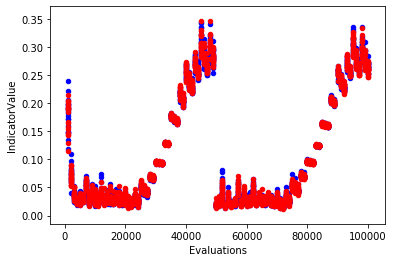

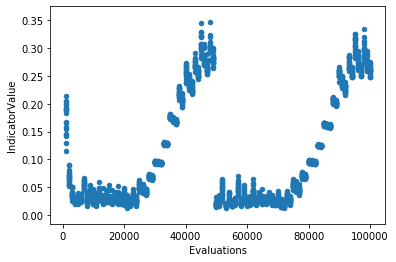

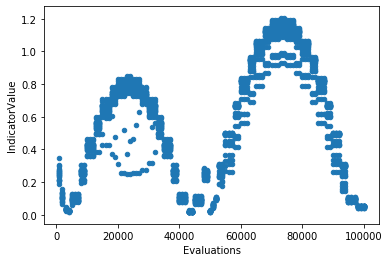

In [104]:
df[(df["Algorithm"] == "NSGAII") & (df["Problem"] == "UDF2")].plot(x="Evaluations", y="IndicatorValue", kind="scatter")

In [138]:
df[(df["Algorithm"] == "NSGAII") & (df["Evaluations"] > 40000) & (df["Evaluations"] < 60000)]

,Algorithm,Problem,ExecutionId,Evaluations,IndicatorName,IndicatorValue
336,NSGAII,UDF2,0,41000,IGD,0.245724
337,NSGAII,UDF2,0,42000,IGD,0.232184
338,NSGAII,UDF2,0,43000,IGD,0.286945
339,NSGAII,UDF2,0,44000,IGD,0.276764
340,NSGAII,UDF2,0,45000,IGD,0.326994
341,NSGAII,UDF2,0,46000,IGD,0.321137
342,NSGAII,UDF2,0,47000,IGD,0.308511
343,NSGAII,UDF2,0,48000,IGD,0.363997
344,NSGAII,UDF2,0,49000,IGD,0.348303
346,NSGAII,UDF2,0,50000,IGD,0.088770


/Users/sizhe/Documents/cmlsga-jmetalpy/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


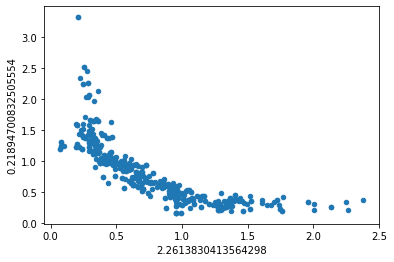

In [112]:
sols = pd.read_csv("data-500pop-100000evals-1runs-debug/MOEAD/UDF2/FUN.0.tsv.10000", delimiter="\ ")
sols.plot(x=0, y=1, kind="scatter")

In [212]:
def get_average_igd(df, algorithms, problems, evaluations):
    igd_df = pd.DataFrame(columns=["Problem", "Evaluations"] + [a for a in algorithms])
    for p in problems:
        for e in evaluations:
            row = {
                "Problem": p
            }
            row["Evaluations"] = pd.to_numeric(e)

            for a in algorithms:
                igds = df[(df["Algorithm"] == a) & (df["Problem"] == p) & (df["Evaluations"] == e)]["IndicatorValue"]
                row[a] = np.average(igds)

            igd_df = igd_df.append(row, ignore_index=True)
    
    igd_df["Evaluations"] = pd.to_numeric(igd_df["Evaluations"])
    return igd_df

def get_difference(df, algorithm1, algorithm2):
    diff = []

    for p in df["Problem"].unique():
        for e in df["Evaluations"].unique():
            ag1 = df[(df["Problem"] == p) & (df["Evaluations"] == e)][algorithm1]
            ag2 = df[(df["Problem"] == p) & (df["Evaluations"] == e)][algorithm2]

            diff.append(float(ag1 - ag2))

    return diff

In [211]:
igd_df = get_average_igd(df, ["MOEAD", "MOEAD-e"], problems_udf, [i for i in range(1000, 101000, 1000)])

In [213]:
diff = get_difference(igd_df, "MOEAD", "MOEAD-e")
igd_df["Difference"] = diff

In [232]:
igd_df["Diff %"] = igd_df["Difference"] / igd_df["MOEAD"] * 100

In [230]:
igd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 6 columns):
Problem        700 non-null object
Evaluations    700 non-null int64
MOEAD          700 non-null float64
MOEAD-e        700 non-null float64
Difference     700 non-null float64
Diff %         700 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 32.9+ KB


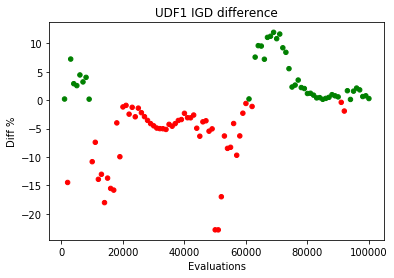

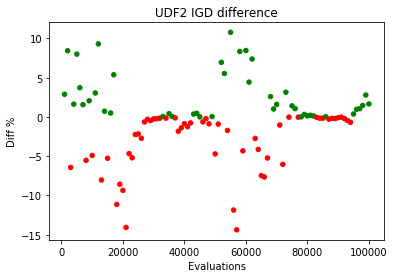

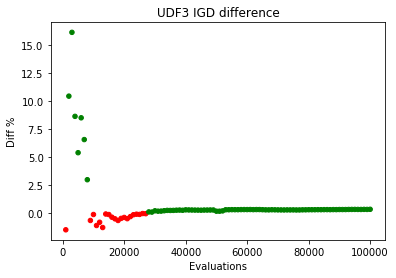

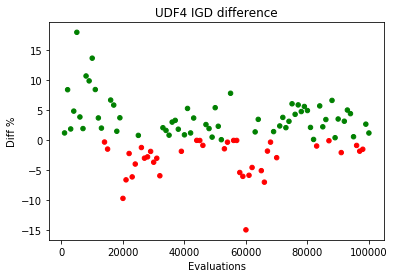

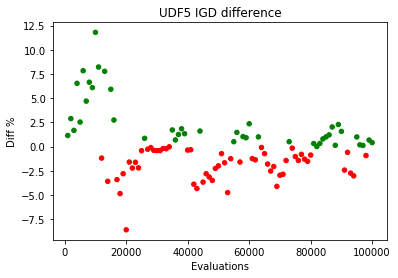

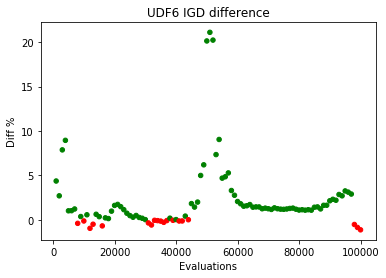

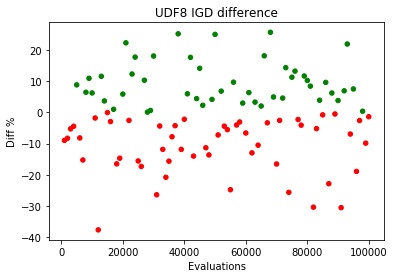

In [233]:
for p in igd_df["Problem"].unique():
    igd_df[(igd_df["Problem"] == p)].plot(x="Evaluations", y="Diff %", kind="scatter",
                                          title="{} IGD difference".format(p),
                                          color=np.where(igd_df[(igd_df["Problem"] == p)]["Diff %"] > 0, 'g', 'r'))

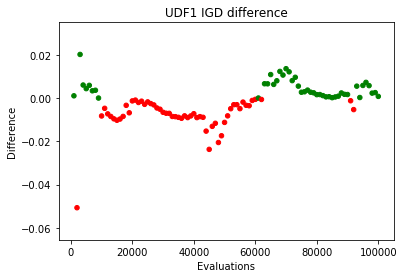

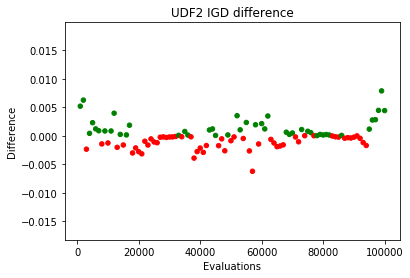

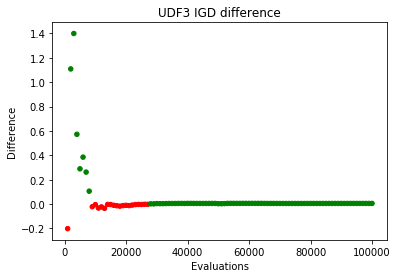

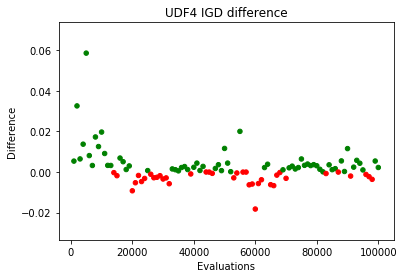

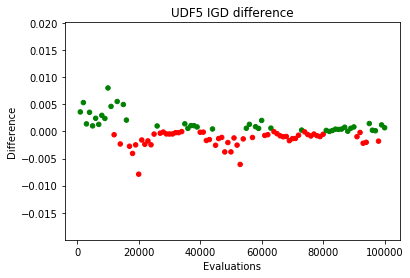

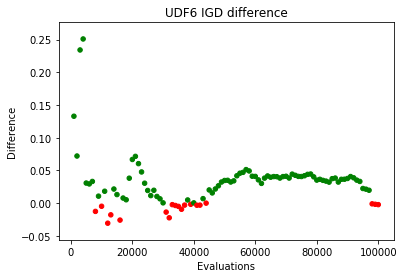

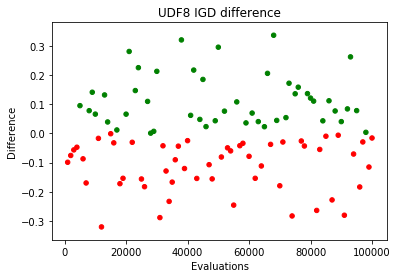

In [223]:
for p in igd_df["Problem"].unique():
    igd_df[(igd_df["Problem"] == p)].plot(x="Evaluations", y="Difference", kind="scatter",
                                          title="{} IGD difference".format(p),
                                          color=np.where(igd_df[(igd_df["Problem"] == p)]["Difference"] > 0, 'g', 'r'))

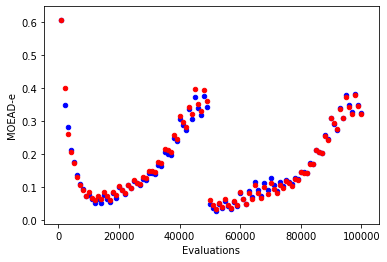

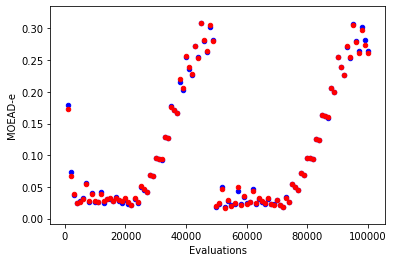

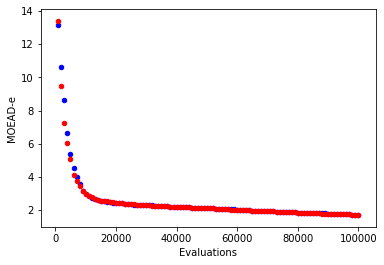

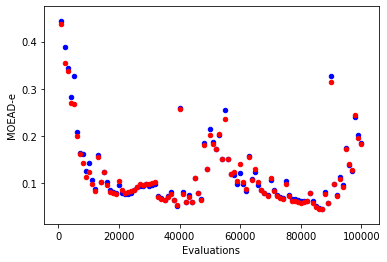

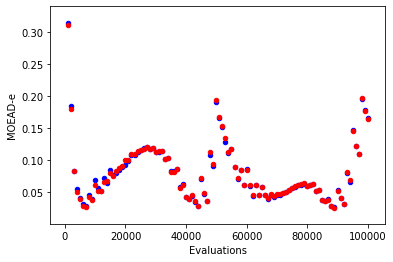

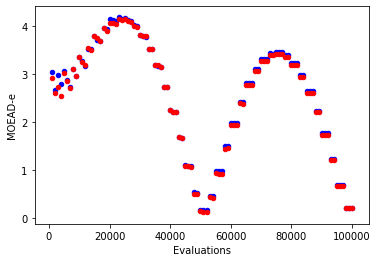

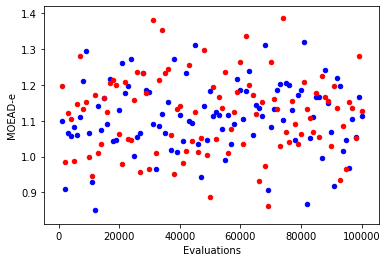

In [235]:
for p in igd_df["Problem"].unique():
    ax1 = igd_df[igd_df["Problem"] == p].plot(x="Evaluations", y="MOEAD", kind="scatter", color='b')
    ax2 = igd_df[igd_df["Problem"] == p].plot(x="Evaluations", y="MOEAD-e", kind="scatter", color='r', ax=ax1)

In [42]:
def write_igd_csv(filename, df, problems):
    with open('igd.csv', 'w+') as of:
            of.write('Algorithm,Problem,Evaluations,IGD-avg,IDG-std\n')

    for algorithm in ["MOEAD", "MOEAD-e"]:
        for problem in problems:
            for evals in range(1000, 100000, 1000):
                igd_df = df[(df["Problem"] == problem) 
                            & (df["Evaluations"] == evals) 
                            & (df["Algorithm"] == algorithm)]["IndicatorValue"]

                with open("igd.csv", "a+") as f:
                    f.write(",".join([algorithm, problem, str(evals), str(np.average(igd_df)), str(np.std(igd_df))]))
                    f.write("\n")

In [43]:
def write_raw_csv(filename, df, problems):
    with open(filename, "w+") as f:
        for algorithm in ["MOEAD", "MOEAD-e"]:
            for evals in range(1000, 101000, 1000):
                f.write(",".join([algorithm, str(evals)]))
                for problem in problems:
                    igd_df = df[(df["Problem"] == problem)
                                & (df["Algorithm"] == algorithm)
                                & (df["Evaluations"] == evals)]            

                    f.write(",{}".format(problem))
                    for i, row in igd_df.iterrows():
                        f.write(",{}".format(row["IndicatorValue"]))

                f.write("\n")

In [54]:
df_random_block = pd.read_csv("randomBlock1-10.csv")

In [53]:
df_random_proba = pd.read_csv("randomProba.csv")

In [56]:
df_random_block_var = pd.read_csv("randomBlock1-var2.csv")

In [58]:
problems = problems_udf + problems_jy
write_raw_csv("randomBlock1-10-raw.csv", df_random_block, problems)
write_raw_csv("randomBlock1-var2-raw.csv", df_random_block_var, problems)
write_raw_csv("randomProba-raw.csv", df_random_proba, problems)

In [65]:
def write_average_igd(filename, df, problems):
    with open(filename, "w+") as f:
        f.write(",".join(["Evaluations"] + problems))
        f.write("\n")
        for evals in range(1000, 101000, 1000):
            f.write("{}".format(evals))
            for problem in problems:
                igd_df = df[(df["Problem"] == problem)
                           & (df["Algorithm"] == "MOEAD-e")
                           & (df["Evaluations"] == evals)]
                f.write(",{}".format(np.average(igd_df["IndicatorValue"])))
            f.write("\n")

In [68]:
write_average_igd("average-igd.csv", df_random_block, problems)